# **Import all the packages**

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline
import cv2
from tqdm import tqdm_notebook, tnrange
from glob import glob
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split
import tensorflow as tf
from skimage.color import rgb2gray
from tensorflow.keras import Input
from tensorflow.keras.models import Model, load_model, save_model
from tensorflow.keras.layers import Input, Activation, BatchNormalization, Dropout, Lambda, Conv2D, Conv2DTranspose, MaxPooling2D, concatenate, Concatenate, UpSampling2D, Add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
#Set Parameters
im_width = 256
im_height = 256

# **Problem Statement**

# **Data Sources**

In [3]:
# load the dataset including all images and masks

train_files = []
mask_files = glob('../input/lgg-mri-segmentation/kaggle_3m/*/*_mask*')
print(len(mask_files))

for i in mask_files:
    train_files.append(i.replace('_mask',''))

print(train_files[:10])
print(mask_files[:10])

3929
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_56.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_8.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_34.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_33.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_43.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_39.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_7.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_31.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_6.tif', '../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19860307/TCGA_DU_7010_19860307_38.tif']
['../input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7010_19

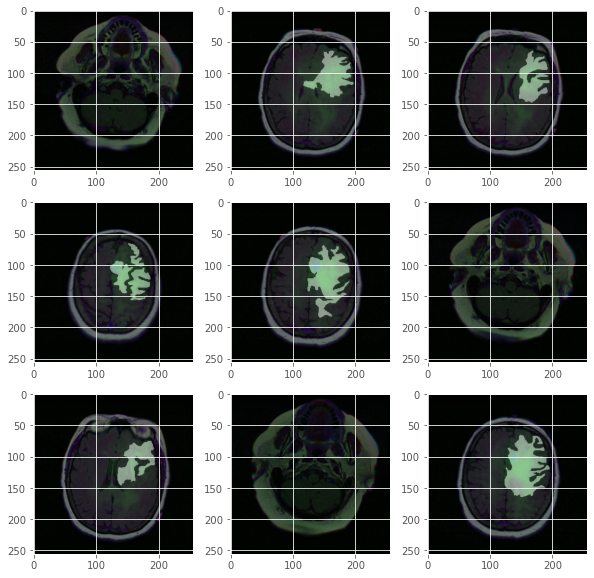

In [4]:
# plot some samples with images and masks together

rows, cols = 3, 3
fig = plt.figure(figsize=(10,10))
for i in range(1,rows * cols + 1):
    fig.add_subplot(rows, cols, i)
    img_path = train_files[i]
    msk_path = mask_files[i]
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    msk = cv2.imread(msk_path)
    plt.imshow(img)
    plt.imshow(msk, alpha=0.4)
plt.show()

# **Exploratory Analysis of Data**

# **Create data frame and split data on train set, validation set and test set**

In [4]:
df = pd.DataFrame(data={"filename": train_files, 'mask' : mask_files})
df_train, df_test = train_test_split(df,test_size = 0.1)
df_train, df_val = train_test_split(df_train,test_size = 0.2)
print(df_train.values.shape)
print(df_val.values.shape)
print(df_test.values.shape)

(2828, 2)
(708, 2)
(393, 2)


# **Data genertator, data augmentation and adjust data**

In [26]:
# From: https://github.com/zhixuhao/unet/blob/master/data.py
def train_generator(data_frame, batch_size, aug_dict,
        image_color_mode="rgb",
        mask_color_mode="grayscale",
        image_save_prefix="image",
        mask_save_prefix="mask",
        save_to_dir=None,
        target_size=(256,256),
        seed=1):
    '''
    can generate image and mask at the same time use the same seed for
    image_datagen and mask_datagen to ensure the transformation for image
    and mask is the same if you want to visualize the results of generator,
    set save_to_dir = "your path"
    '''
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow_from_dataframe(
        data_frame,
        x_col = "filename",
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)

    mask_generator = mask_datagen.flow_from_dataframe(
        data_frame,
        x_col = "mask",
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)

    train_gen = zip(image_generator, mask_generator)

    for (img, mask) in train_gen:
        img, mask = adjust_data(img, mask)
        yield (img,mask)

def adjust_data(img,mask):
    img = img / 255
    mask = mask / 255
    mask[mask > 0.5] = 1
    mask[mask <= 0.5] = 0

    return (img, mask)

# **Define loss function and metrics**

In [27]:
smooth=100

def dice_coef(y_true, y_pred):
    y_truef=K.flatten(y_true)
    y_predf=K.flatten(y_pred)
    And=K.sum(y_truef* y_predf)
    return((2* And + smooth) / (K.sum(y_truef) + K.sum(y_predf) + smooth))

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    intersection = K.sum(y_true * y_pred)
    sum_ = K.sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

# **Models**

### **UNet**

The UNet consists of a contracting path on the left and an expanding path on the right. The contracting path is a typical convolutional network that consists of repeated application of convolutions, each followed by a rectified linear unit (ReLU) and a max pooling operation. During the contraction, the spatial information is reduced while feature information is improved. The expanding path combines the feature and spatial information through a sequence of up-convolutions and concatenations with high-resolution features from the contracting path.

![UNet](https://miro.medium.com/max/1200/1*f7YOaE4TWubwaFF7Z1fzNw.png)

In [8]:
def unet(input_size=(256,256,3)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(64, (3, 3), padding='same')(inputs)
    bn1 = Activation('relu')(conv1)
    conv1 = Conv2D(64, (3, 3), padding='same')(bn1)
    bn1 = BatchNormalization(axis=3)(conv1)
    bn1 = Activation('relu')(bn1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, (3, 3), padding='same')(pool1)
    bn2 = Activation('relu')(conv2)
    conv2 = Conv2D(128, (3, 3), padding='same')(bn2)
    bn2 = BatchNormalization(axis=3)(conv2)
    bn2 = Activation('relu')(bn2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, (3, 3), padding='same')(pool2)
    bn3 = Activation('relu')(conv3)
    conv3 = Conv2D(256, (3, 3), padding='same')(bn3)
    bn3 = BatchNormalization(axis=3)(conv3)
    bn3 = Activation('relu')(bn3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(bn3)

    conv4 = Conv2D(512, (3, 3), padding='same')(pool3)
    bn4 = Activation('relu')(conv4)
    conv4 = Conv2D(512, (3, 3), padding='same')(bn4)
    bn4 = BatchNormalization(axis=3)(conv4)
    bn4 = Activation('relu')(bn4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(bn4)

    conv5 = Conv2D(1024, (3, 3), padding='same')(pool4)
    bn5 = Activation('relu')(conv5)
    conv5 = Conv2D(1024, (3, 3), padding='same')(bn5)
    bn5 = BatchNormalization(axis=3)(conv5)
    bn5 = Activation('relu')(bn5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), padding='same')(up6)
    bn6 = Activation('relu')(conv6)
    conv6 = Conv2D(512, (3, 3), padding='same')(bn6)
    bn6 = BatchNormalization(axis=3)(conv6)
    bn6 = Activation('relu')(bn6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), padding='same')(up7)
    bn7 = Activation('relu')(conv7)
    conv7 = Conv2D(256, (3, 3), padding='same')(bn7)
    bn7 = BatchNormalization(axis=3)(conv7)
    bn7 = Activation('relu')(bn7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(bn7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), padding='same')(up8)
    bn8 = Activation('relu')(conv8)
    conv8 = Conv2D(128, (3, 3), padding='same')(bn8)
    bn8 = BatchNormalization(axis=3)(conv8)
    bn8 = Activation('relu')(bn8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(bn8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), padding='same')(up9)
    bn9 = Activation('relu')(conv9)
    conv9 = Conv2D(64, (3, 3), padding='same')(bn9)
    bn9 = BatchNormalization(axis=3)(conv9)
    bn9 = Activation('relu')(bn9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(bn9)

    return Model(inputs=[inputs], outputs=[conv10], name='Unet')

### **Attention UNet**

Attention UNet introduces an attention mechanism based on UNet. Before stitching the features at each resolution of the encoder with the corresponding features in the decoder, an attention module is used to adjustadjust the output features of the encoder. This module generates a gating signal to control the importance of features at different spatial locations, as shown by the red circles in the figure below.

![UNet](https://www.researchgate.net/publication/324472010/figure/fig1/AS:614439988494349@1523505317982/A-block-diagram-of-the-proposed-Attention-U-Net-segmentation-model-Input-image-is.png)

The attention module is combined with ReLU and Sigmoid through 1x1x1 convolution to generate a weight map a, and the feature is corrected by multiplying it with the feature in the encoder.

![UNet](https://jinglescode.github.io/assets/img/posts/unet-attention-04.jpg)

In [9]:
def attention_unet(input_size=(256,256,3)):
    
    def conv_block(inp,filters):
        x=Conv2D(filters,(3,3),padding='same',activation='relu')(inp)
        x=Conv2D(filters,(3,3),padding='same')(x)
        x=BatchNormalization(axis=3)(x)
        x=Activation('relu')(x)
        return x

    def encoder_block(inp,filters,dropout):
        x=conv_block(inp,filters)
        p=MaxPooling2D(pool_size=(2,2))(x)
        p=Dropout(dropout)(p)
        return x,p

    def attention_block(l_layer,h_layer): #Attention Block
        phi=Conv2D(h_layer.shape[-1],(1,1),padding='same')(l_layer)
        theta=Conv2D(h_layer.shape[-1],(1,1),strides=(2,2),padding='same')(h_layer)
        x=tf.keras.layers.add([phi,theta])
        x=Activation('relu')(x)
        x=Conv2D(1,(1,1),padding='same',activation='sigmoid')(x)
        x=UpSampling2D(size=(2,2))(x)
        x=tf.keras.layers.multiply([h_layer,x])
        x=BatchNormalization(axis=3)(x)
        return x

    def decoder_block(inp,filters,concat_layer,dropout):
        x=Conv2DTranspose(filters,(2,2),strides=(2,2),padding='same')(inp)
        concat_layer=attention_block(inp,concat_layer)
        x=concatenate([x,concat_layer])
        x=Dropout(dropout)(x)
        x=conv_block(x,filters)
        return x
    
    inputs = Input(input_size)
    d1,p1=encoder_block(inputs,64,0.1)
    d2,p2=encoder_block(p1,128,0.1)
    d3,p3=encoder_block(p2,256,0.1)
    d4,p4=encoder_block(p3,512,0.1)
    b1=conv_block(p4,1024)
    e2=decoder_block(b1,512,d4,0.1)
    e3=decoder_block(e2,256,d3,0.1)
    e4=decoder_block(e3,128,d2,0.1)
    e5=decoder_block(e4,64,d1,0.1)
    outputs = Conv2D(1, (1,1),activation="sigmoid")(e5)
    return Model(inputs=[inputs], outputs=[outputs], name='AttentionUnet')

### **ResUNet**

The ResUNet consists of an encoding network, decoding network and a bridge connecting both these networks, just like a UNet. The UNet uses two 3 x 3 convolution, where each is followed by a ReLU activation function. In the case of ResUNet, these layers are replaced by a pre-activated residual block.

The encoder takes the input image and passes it through different encoder blocks, which helps the network to learn an abstract representation.

The decoder consists of three decoder blocks, and after each block, the spatial dimensions of the feature map are doubles and the number of feature channels is reduced. It takes the feature map from the bridge and the skip connections from different encoder block and learns a better semantic representation, which is used to generate a segmentation mask.



![ResUNet](https://miro.medium.com/max/561/0*Q9iM4_vhdCYDlTsO.png)

In [22]:
def res_unet(input_size=(256,256,3)):
    def resblock(X, f):
        '''
        function for creating res block
        '''
        X_copy = X  #copy of input

        # main path
        X = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X)
        X = BatchNormalization()(X)
        X = Activation('relu')(X)

        X = Conv2D(f, kernel_size=(3,3), padding='same', kernel_initializer='he_normal')(X)
        X = BatchNormalization()(X)

        # shortcut path
        X_copy = Conv2D(f, kernel_size=(1,1), kernel_initializer='he_normal')(X_copy)
        X_copy = BatchNormalization()(X_copy)

        # Adding the output from main path and short path together
        X = Add()([X, X_copy])
        X = Activation('relu')(X)

        return X

    def upsample_concat(x, skip):
        '''
        funtion for upsampling image
        '''
        X = UpSampling2D((2,2))(x)
        merge = Concatenate()([X, skip])

        return merge

    inputs = Input(input_size) #iniating tensor of input shape

    # Stage 1
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)
    conv_1 = BatchNormalization()(conv_1)
    conv_1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv_1)
    conv_1 = BatchNormalization()(conv_1)
    pool_1 = MaxPooling2D((2,2))(conv_1)

    # stage 2
    conv_2 = resblock(pool_1, 32)
    pool_2 = MaxPooling2D((2,2))(conv_2)

    # Stage 3
    conv_3 = resblock(pool_2, 64)
    pool_3 = MaxPooling2D((2,2))(conv_3)

    # Stage 4
    conv_4 = resblock(pool_3, 128)
    pool_4 = MaxPooling2D((2,2))(conv_4)
    
    # Stage 5 (bottle neck)
    conv_5 = resblock(pool_4, 256)

    # Upsample Stage 1
    up_1 = upsample_concat(conv_5, conv_4)
    up_1 = resblock(up_1, 128)

    # Upsample Stage 2
    up_2 = upsample_concat(up_1, conv_3)
    up_2 = resblock(up_2, 64)

    # Upsample Stage 3
    up_3 = upsample_concat(up_2, conv_2)
    up_3 = resblock(up_3, 32)

    # Upsample Stage 4
    up_4 = upsample_concat(up_3, conv_1)
    up_4 = resblock(up_4, 16)

    # final output
    outputs = Conv2D(1, (1,1), kernel_initializer='he_normal', padding='same', activation='sigmoid')(up_4)

    return Model(inputs=[inputs], outputs=[outputs], name='ResUnet')
    

# **Training**

In [24]:
EPOCHS = 70
BATCH_SIZE = 32
learning_rate = 0.01

In [28]:
train_generator_args = dict(rotation_range=0.2,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05,
                            zoom_range=0.05,
                            horizontal_flip=True,
                            fill_mode='nearest')
train_gen = train_generator(df_train, BATCH_SIZE,
                                train_generator_args,
                                target_size=(im_height, im_width))
    
test_gener = train_generator(df_val, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))

In [22]:
Unet = unet(input_size=(im_height, im_width, 3))



decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
Unet.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

unet_history = Unet.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Epoch 1/70
89/88 [==============================] - ETA: 0s - loss: -0.3040 - binary_accuracy: 0.9497 - iou: 0.1923 - dice_coef: 0.3026
Epoch 00001: val_loss improved from inf to -0.34051, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 78s 881ms/step - loss: -0.3040 - binary_accuracy: 0.9497 - iou: 0.1923 - dice_coef: 0.3026 - val_loss: -0.3405 - val_binary_accuracy: 0.9869 - val_iou: 0.2092 - val_dice_coef: 0.3300
Epoch 2/70
89/88 [==============================] - ETA: 0s - loss: -0.4241 - binary_accuracy: 0.9878 - iou: 0.2827 - dice_coef: 0.4257
Epoch 00002: val_loss improved from -0.34051 to -0.43496, saving model to unet_brain_mri_seg.hdf5
89/88 [==============================] - 79s 883ms/step - loss: -0.4241 - binary_accuracy: 0.9878 - iou: 0.2827 - dice_coef: 0.4257 - val_loss: -0.4350 - val_binary_accuracy: 0.9827 - val_iou: 0.2757 - val_dice_coef: 0.4192
Epoch 3/70
89/88 [==============================] - ETA: 0s - loss: -0.4561 - binary_accu

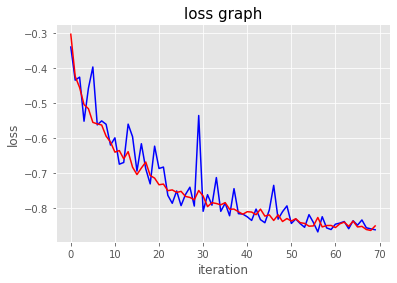

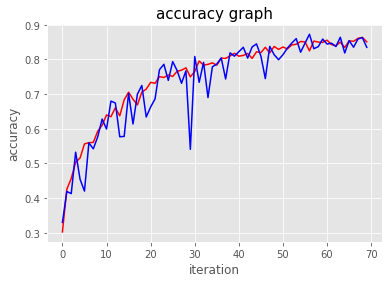

In [23]:
a = unet_history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [24]:
model = load_model('unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 3s 202ms/step - loss: -0.8385 - binary_accuracy: 0.9966 - iou: 0.7266 - dice_coef: 0.8389
Test lost:  -0.8385213017463684
Test IOU:  0.9965803027153015
Test Dice Coefficent:  0.72658771276474


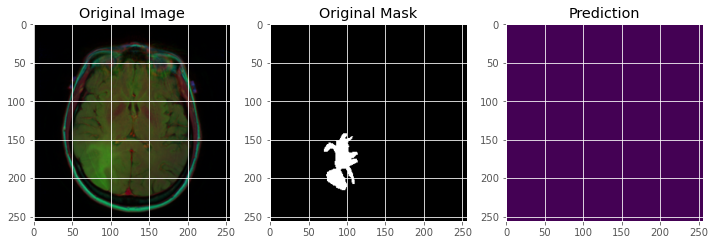

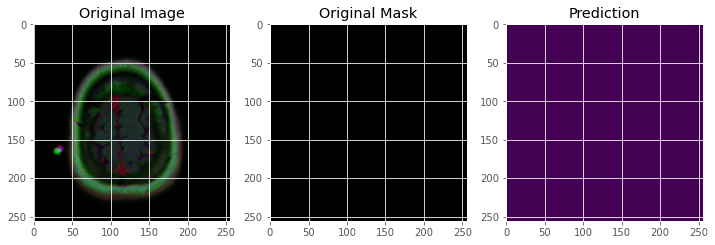

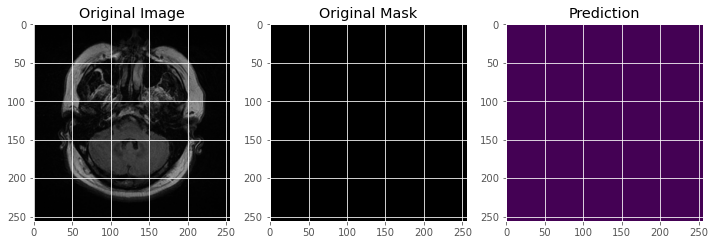

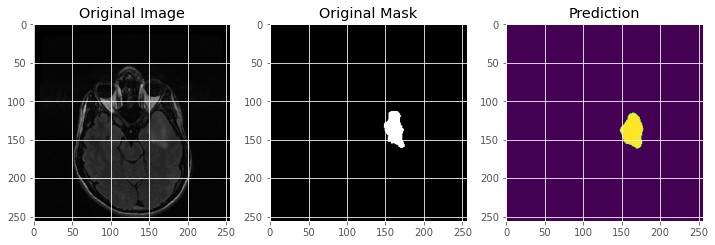

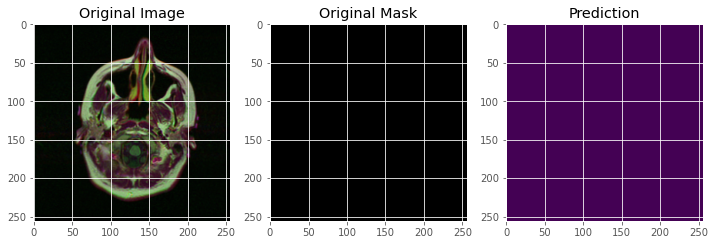

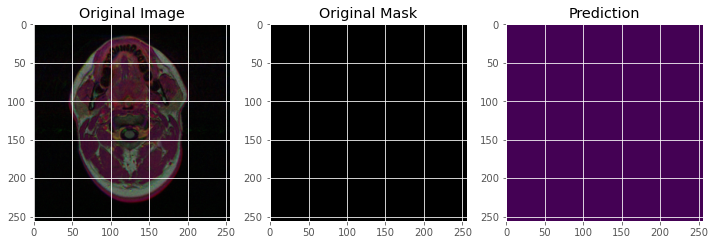

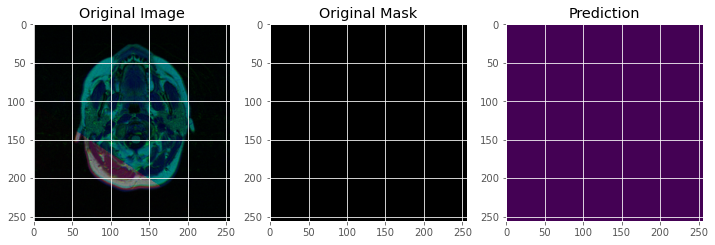

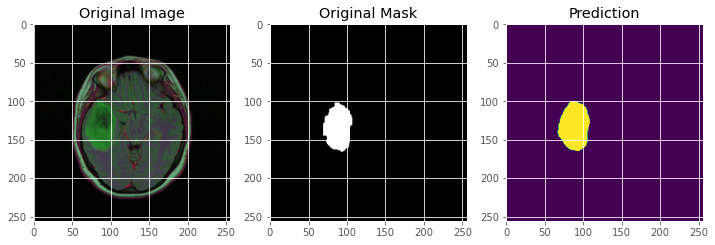

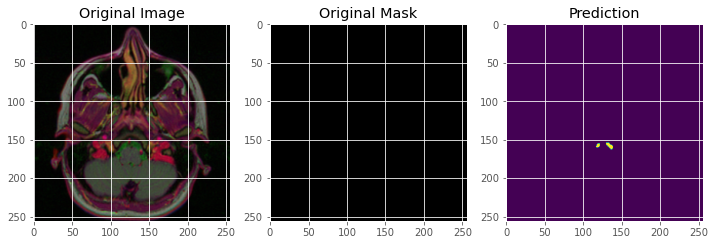

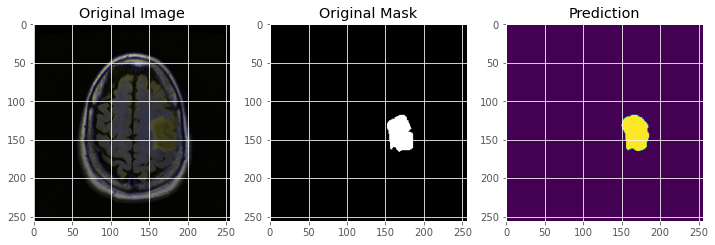

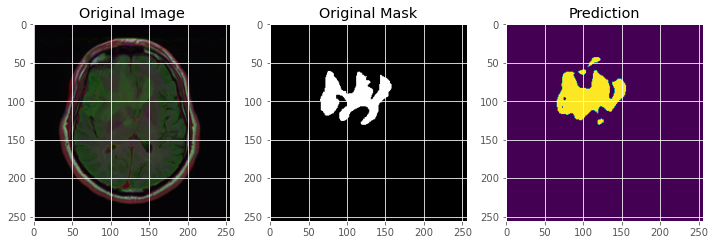

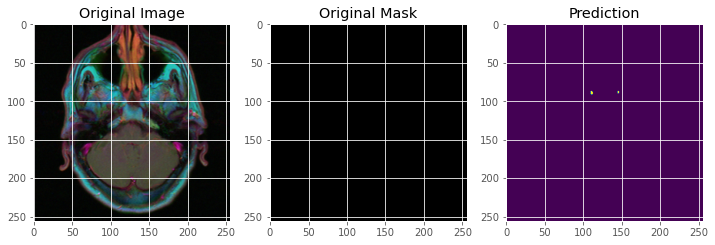

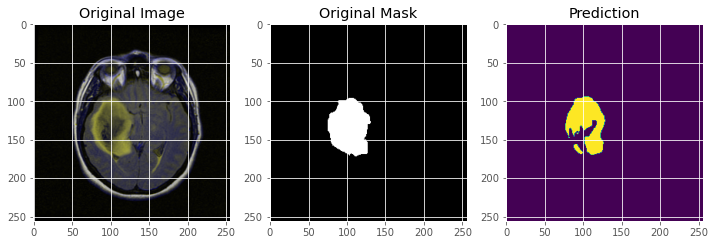

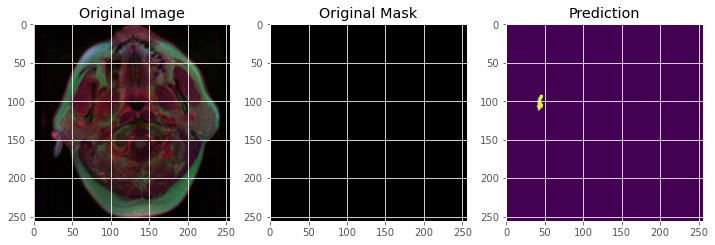

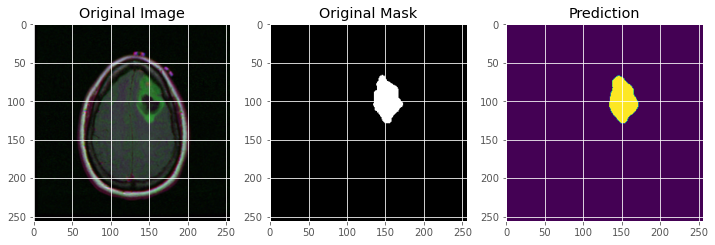

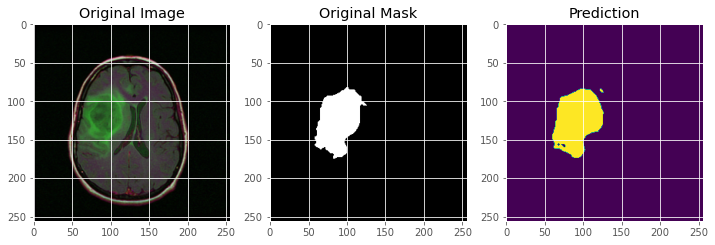

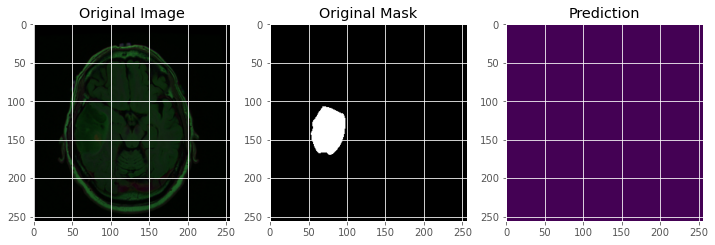

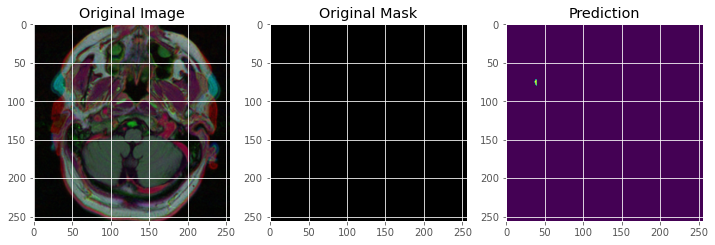

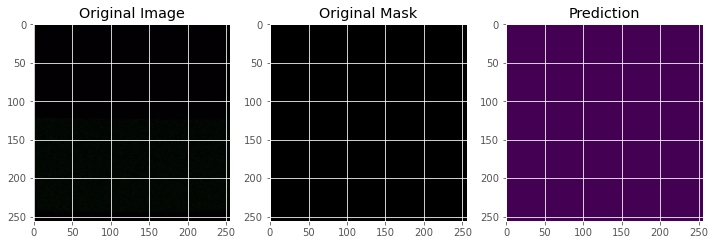

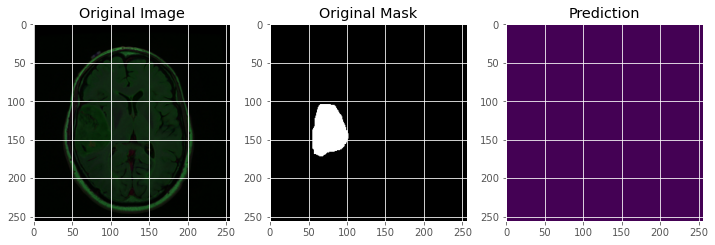

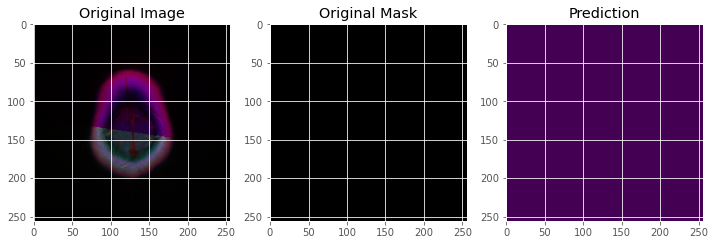

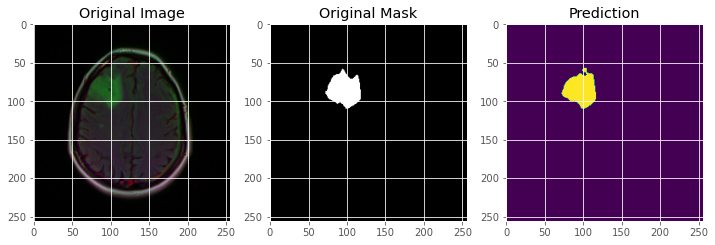

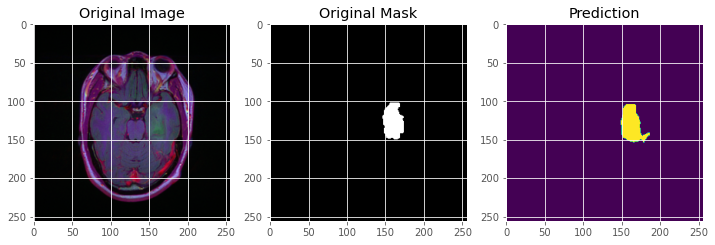

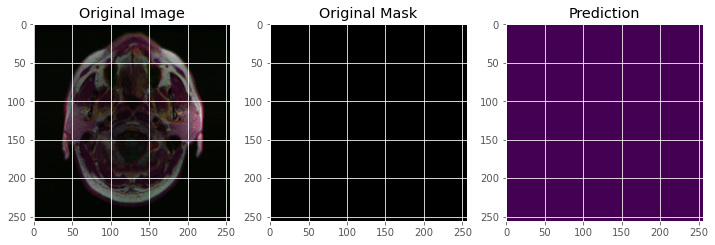

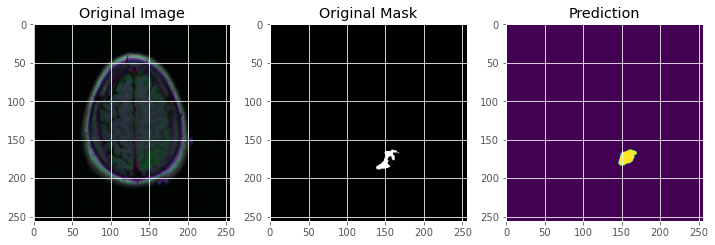

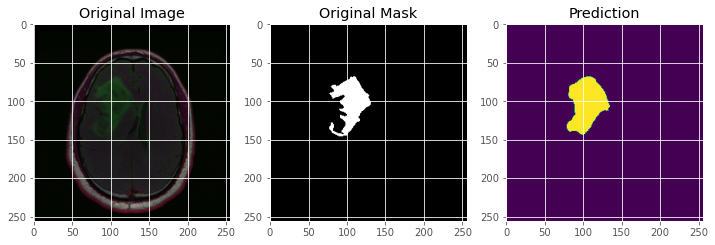

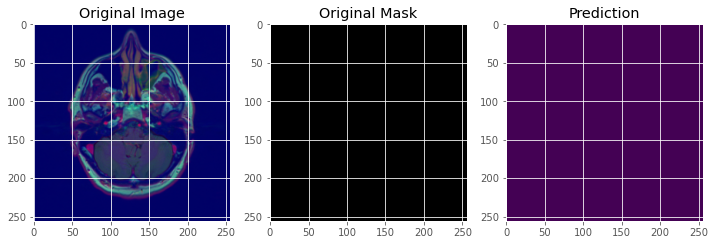

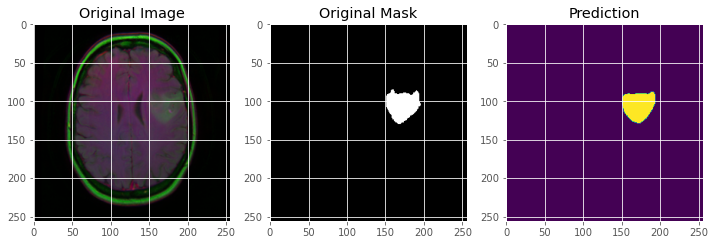

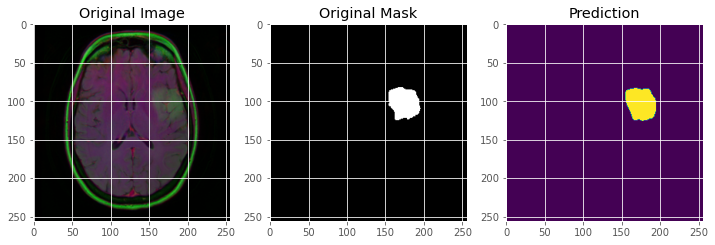

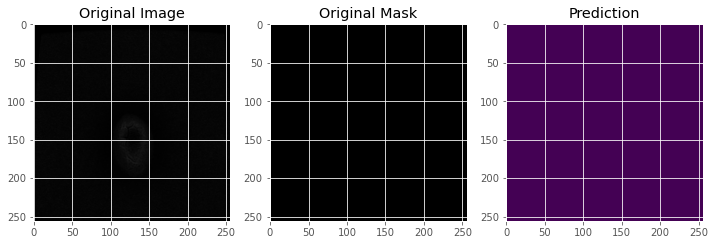

In [26]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

In [15]:
attention_Unet = attention_unet(input_size=(im_height, im_width, 3))


decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
attention_Unet.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('attnetion_unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

attention_history = attention_Unet.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/70
89/88 [==============================] - ETA: 0s - loss: -0.3331 - binary_accuracy: 0.9416 - iou: 0.2200 - dice_coef: 0.3351Found 708 validated image filenames.
Found 708 validated image filenames.

Epoch 00001: val_loss improved from inf to -0.02081, saving model to attnetion_unet_brain_mri_seg.hdf5
89/88 [==============================] - 128s 1s/step - loss: -0.3331 - binary_accuracy: 0.9416 - iou: 0.2200 - dice_coef: 0.3351 - val_loss: -0.0208 - val_binary_accuracy: 0.0219 - val_iou: 0.0104 - val_dice_coef: 0.0206
Epoch 2/70
89/88 [==============================] - ETA: 0s - loss: -0.5370 - binary_accuracy: 0.9917 - iou: 0.3778 - dice_coef: 0.5368
Epoch 00002: val_loss improved from -0.02081 to -0.03269, saving model to attnetion_unet_brain_mri_seg.hdf5
89/88 [==============================] - 88s 994ms/step - loss: -0.5370 - binary_accuracy: 0.9917 - iou: 0.3778 - dice_coef: 0.5368 - val_loss: -

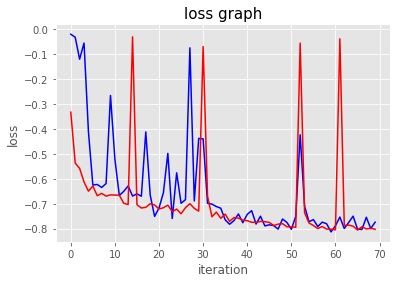

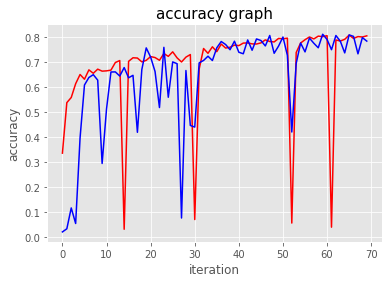

In [17]:
a = attention_history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [18]:
model = load_model('attnetion_unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 7s 507ms/step - loss: -0.7711 - binary_accuracy: 0.9949 - iou: 0.6282 - dice_coef: 0.7682
Test lost:  -0.7711390256881714
Test IOU:  0.994924008846283
Test Dice Coefficent:  0.6282497048377991


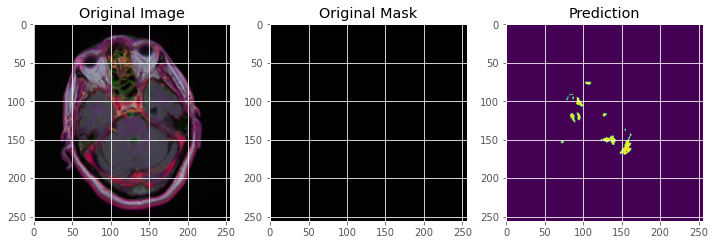

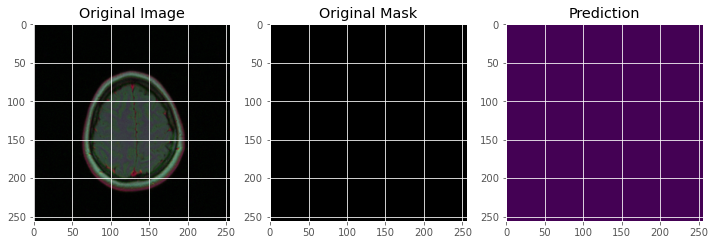

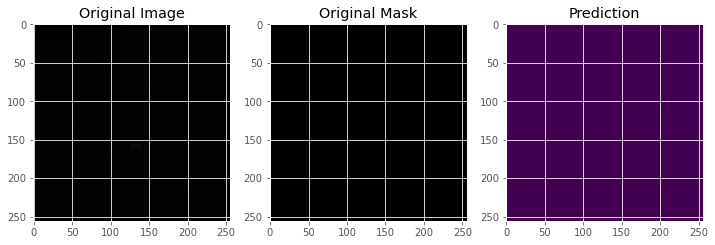

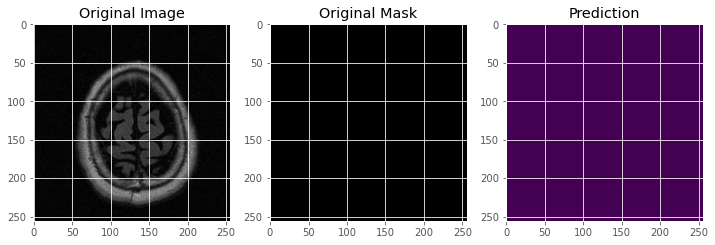

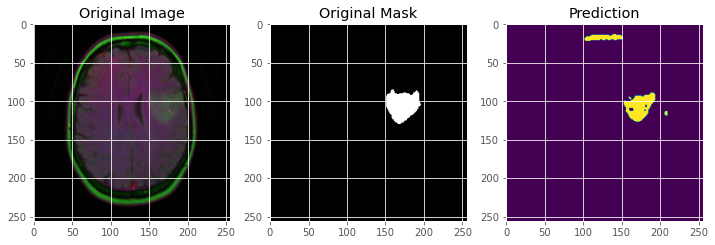

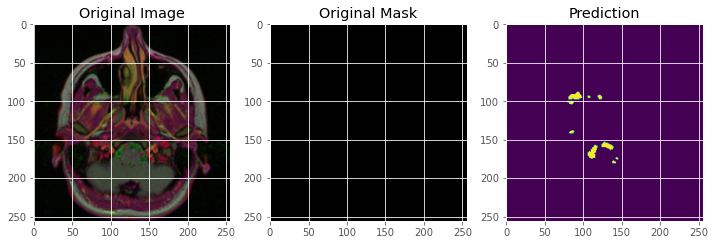

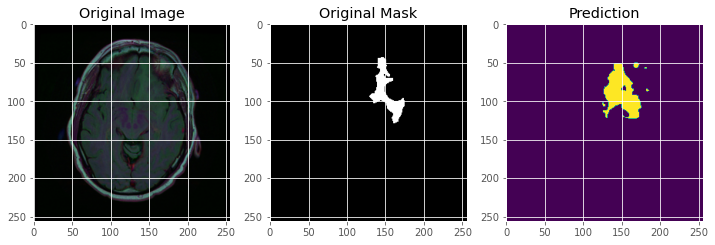

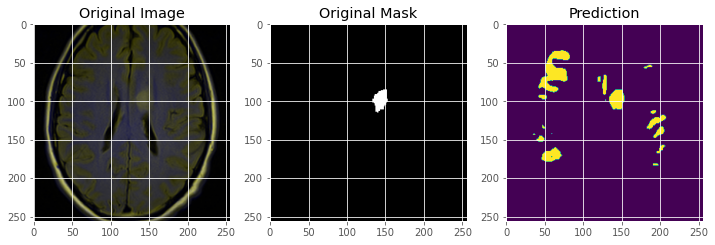

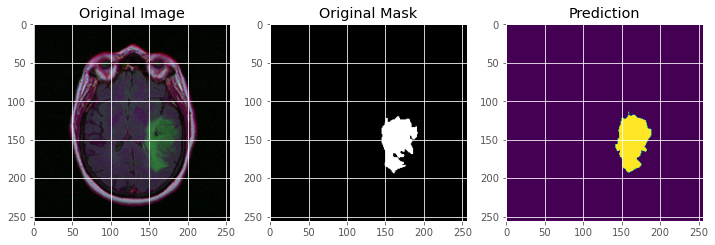

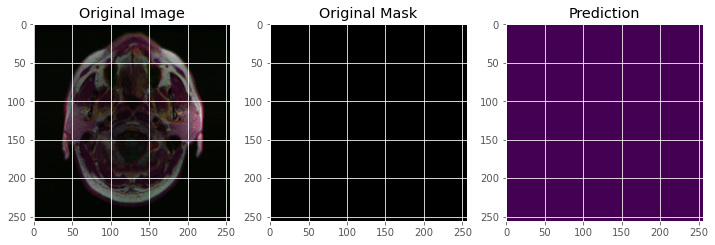

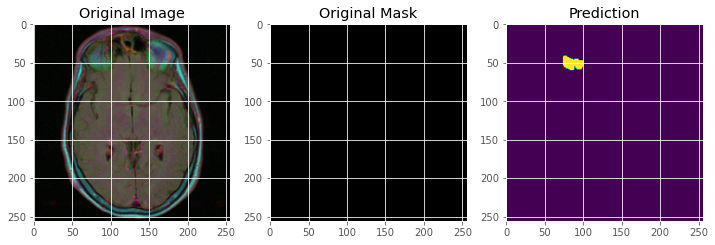

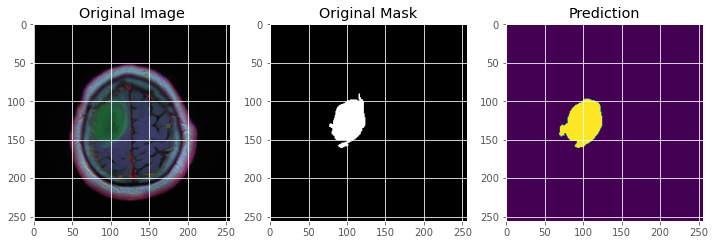

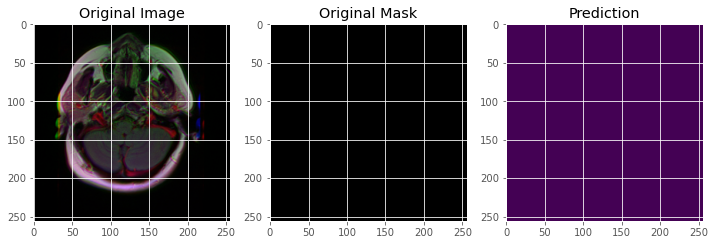

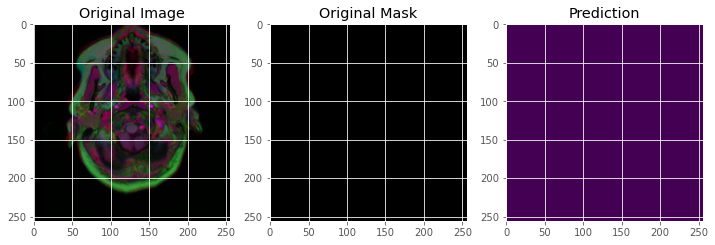

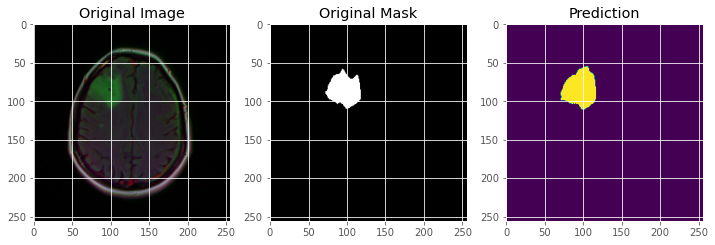

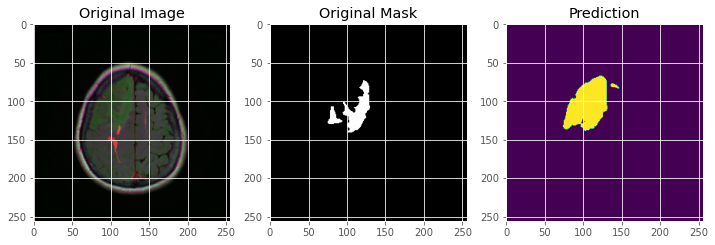

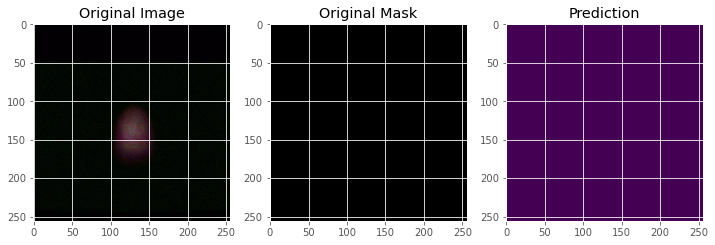

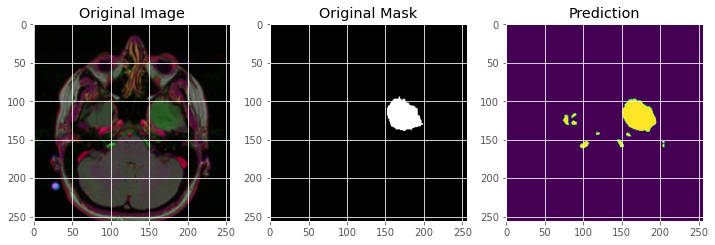

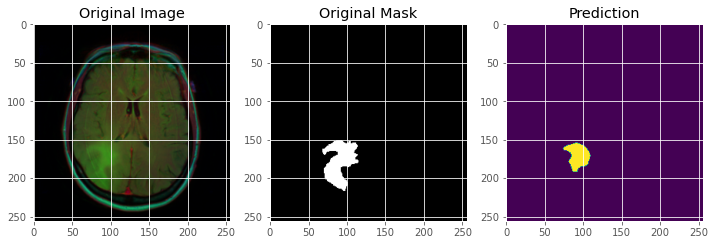

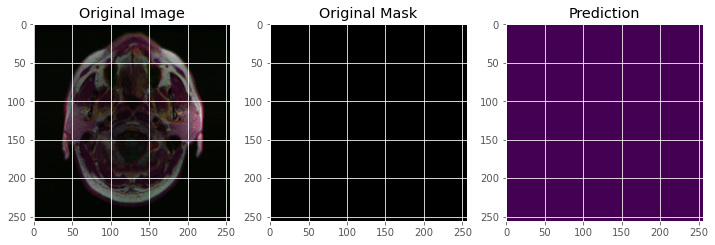

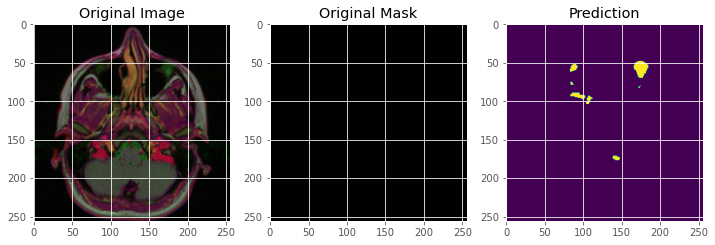

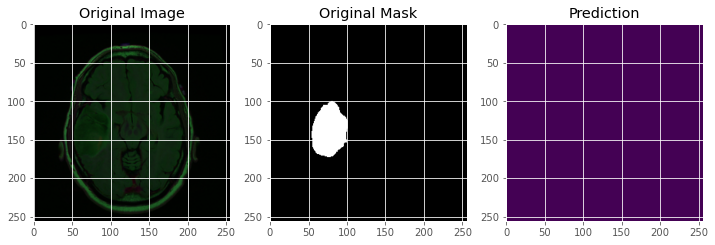

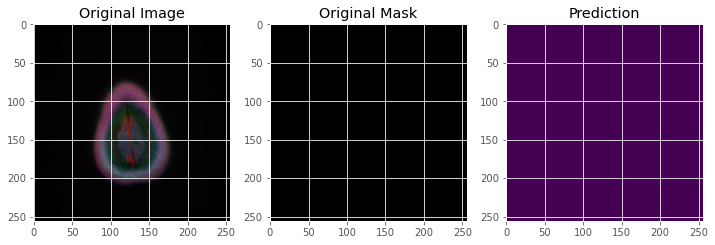

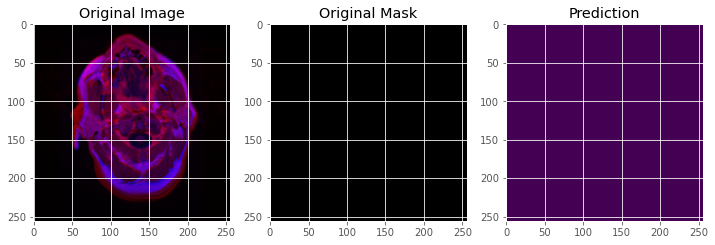

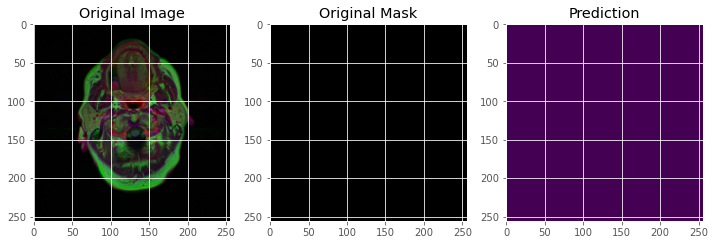

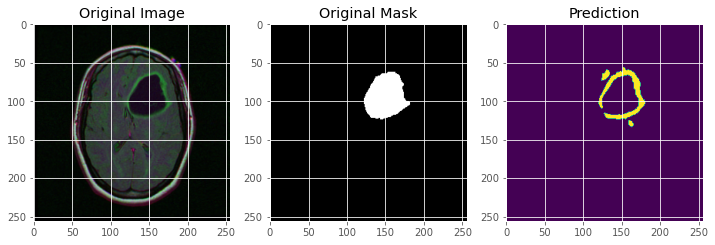

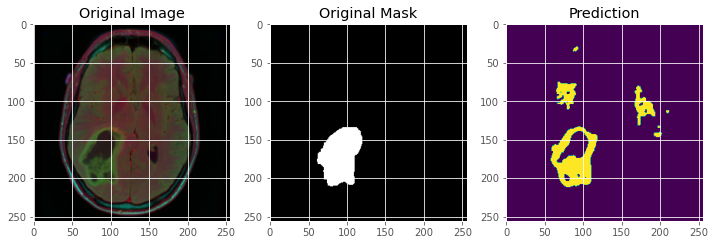

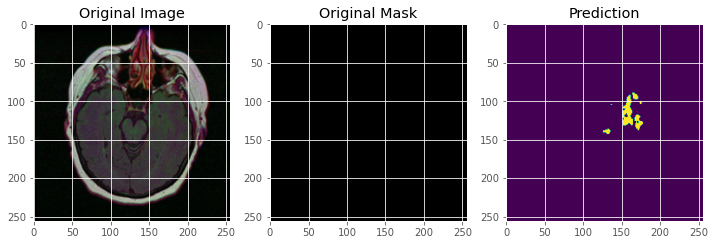

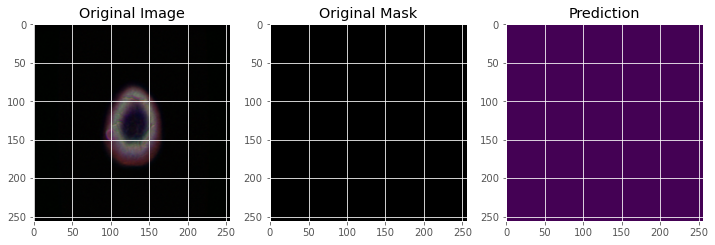

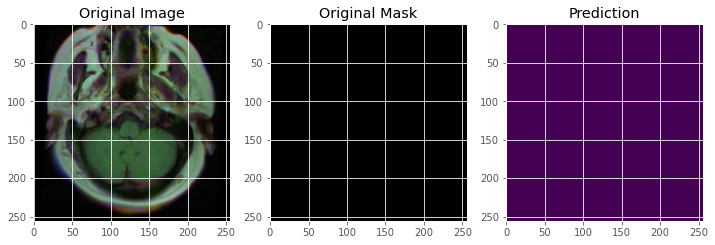

In [21]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

    # attention based Unet
    # Unet++

In [29]:
res_Unet = res_unet(input_size=(im_height, im_width, 3))


decay_rate = learning_rate / EPOCHS
opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=None, decay=decay_rate, amsgrad=False)
res_Unet.compile(optimizer=opt, loss=dice_coef_loss, metrics=["binary_accuracy", iou, dice_coef])

callbacks = [ModelCheckpoint('res_unet_brain_mri_seg.hdf5', verbose=1, save_best_only=True)]

res_history = res_Unet.fit(train_gen,
                    steps_per_epoch=len(df_train) / BATCH_SIZE, 
                    epochs=EPOCHS, 
                    callbacks=callbacks,
                    validation_data = test_gener,
                    validation_steps=len(df_val) / BATCH_SIZE)

Found 2828 validated image filenames.
Found 2828 validated image filenames.
Epoch 1/70
89/88 [==============================] - ETA: 0s - loss: -0.5561 - binary_accuracy: 0.9912 - iou: 0.3989 - dice_coef: 0.5573
Epoch 00002: val_loss improved from -0.02272 to -0.08726, saving model to res_unet_brain_mri_seg.hdf5
89/88 [==============================] - 61s 684ms/step - loss: -0.5561 - binary_accuracy: 0.9912 - iou: 0.3989 - dice_coef: 0.5573 - val_loss: -0.0873 - val_binary_accuracy: 0.9208 - val_iou: 0.0464 - val_dice_coef: 0.0857
Epoch 3/70
89/88 [==============================] - ETA: 0s - loss: -0.6210 - binary_accuracy: 0.9929 - iou: 0.4607 - dice_coef: 0.6211
Epoch 00003: val_loss improved from -0.08726 to -0.08786, saving model to res_unet_brain_mri_seg.hdf5
89/88 [==============================] - 59s 665ms/step - loss: -0.6210 - binary_accuracy: 0.9929 - iou: 0.4607 - dice_coef: 0.6211 - val_loss: -0.0879 - val_binary_accuracy: 0.7941 - val_iou: 0.0446 - val_dice_coef: 0.0846


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



89/88 [==============================] - ETA: 0s - loss: -0.8271 - binary_accuracy: 0.9967 - iou: 0.7078 - dice_coef: 0.8254
Epoch 00038: val_loss improved from -0.79307 to -0.80737, saving model to res_unet_brain_mri_seg.hdf5
89/88 [==============================] - 61s 686ms/step - loss: -0.8271 - binary_accuracy: 0.9967 - iou: 0.7078 - dice_coef: 0.8254 - val_loss: -0.8074 - val_binary_accuracy: 0.9962 - val_iou: 0.6832 - val_dice_coef: 0.8090
Epoch 39/70
89/88 [==============================] - ETA: 0s - loss: -0.8114 - binary_accuracy: 0.9965 - iou: 0.6881 - dice_coef: 0.8107
Epoch 00040: val_loss improved from -0.80737 to -0.82589, saving model to res_unet_brain_mri_seg.hdf5
89/88 [==============================] - 61s 681ms/step - loss: -0.8114 - binary_accuracy: 0.9965 - iou: 0.6881 - dice_coef: 0.8107 - val_loss: -0.8259 - val_binary_accuracy: 0.9964 - val_iou: 0.7032 - val_dice_coef: 0.8238
Epoch 41/70
89/88 [==============================] - ETA: 0s - loss: -0.8000 - binary_

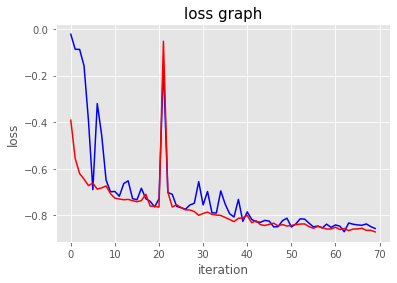

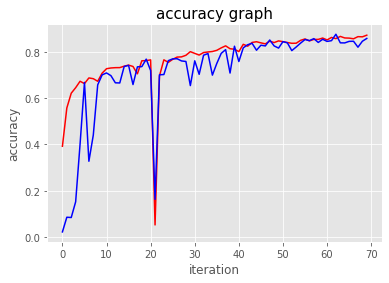

In [30]:
a = res_history.history

list_traindice = a['dice_coef']
list_testdice = a['val_dice_coef']

list_trainjaccard = a['iou']
list_testjaccard = a['val_iou']

list_trainloss = a['loss']
list_testloss = a['val_loss']
plt.figure(1)
plt.plot(list_testloss, 'b-')
plt.plot(list_trainloss,'r-')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('loss graph', fontsize = 15)
plt.figure(2)
plt.plot(list_traindice, 'r-')
plt.plot(list_testdice, 'b-')
plt.xlabel('iteration')
plt.ylabel('accuracy')
plt.title('accuracy graph', fontsize = 15)
plt.show()

In [32]:
model = load_model('res_unet_brain_mri_seg.hdf5', custom_objects={'dice_coef_loss': dice_coef_loss, 'iou': iou, 'dice_coef': dice_coef})

test_gen = train_generator(df_test, BATCH_SIZE,
                                dict(),
                                target_size=(im_height, im_width))
results = model.evaluate(test_gen, steps=len(df_test) / BATCH_SIZE)
print("Test lost: ",results[0])
print("Test IOU: ",results[1])
print("Test Dice Coefficent: ",results[2])

Found 393 validated image filenames.
Found 393 validated image filenames.
13/12 [===============================] - 4s 327ms/step - loss: -0.8036 - binary_accuracy: 0.9971 - iou: 0.6924 - dice_coef: 0.7938
Test lost:  -0.8035616278648376
Test IOU:  0.9971121549606323
Test Dice Coefficent:  0.6924241185188293


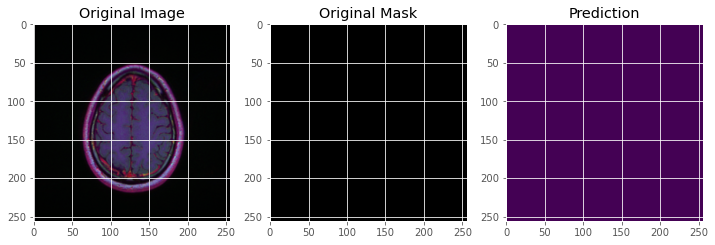

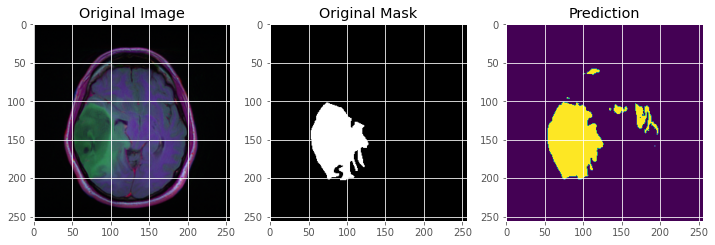

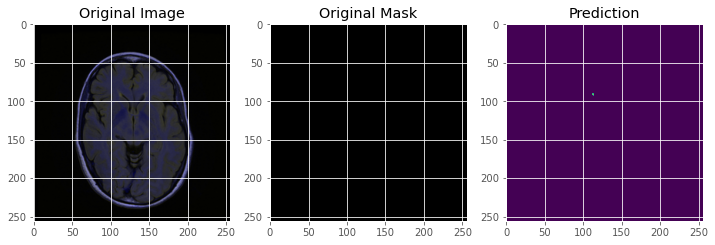

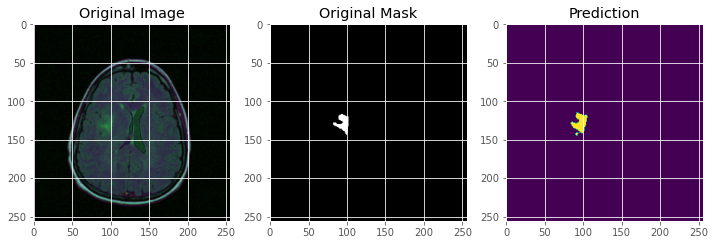

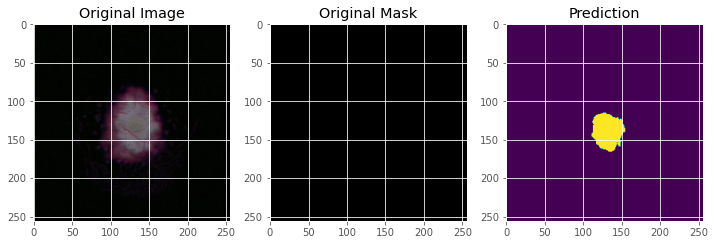

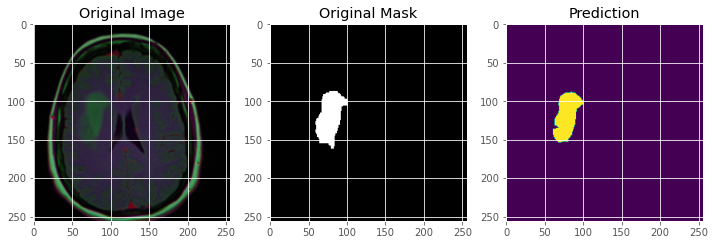

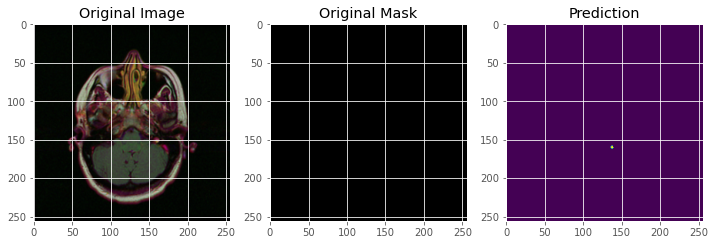

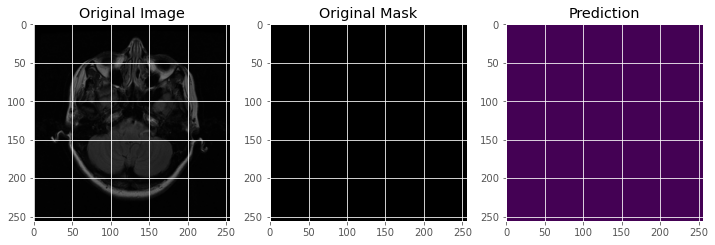

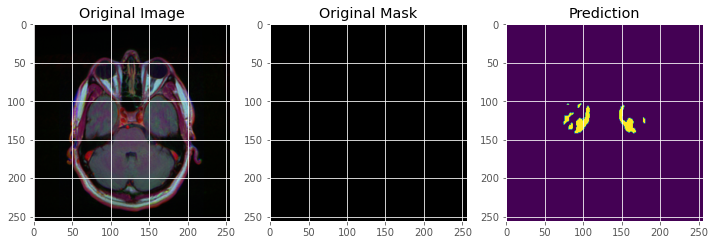

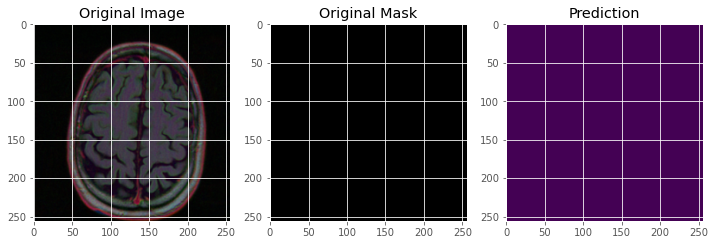

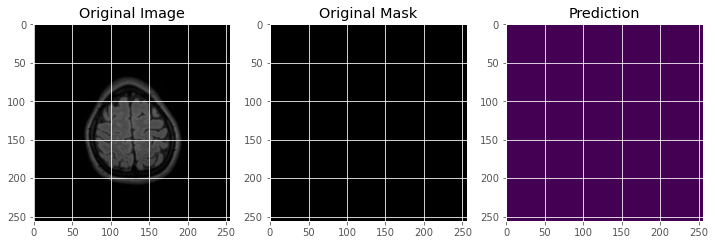

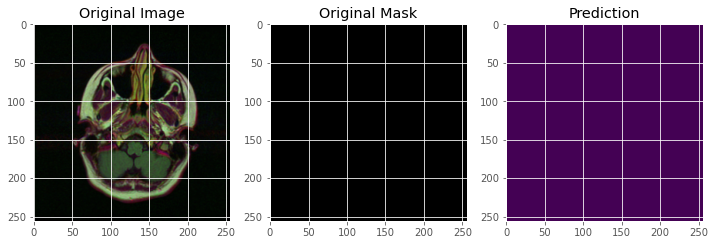

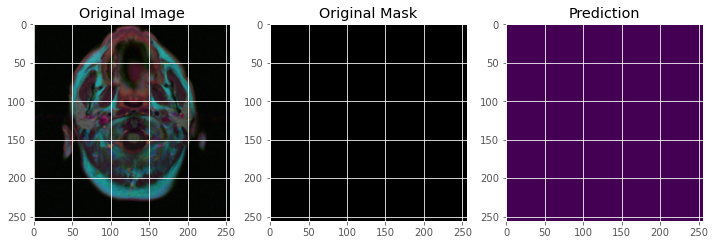

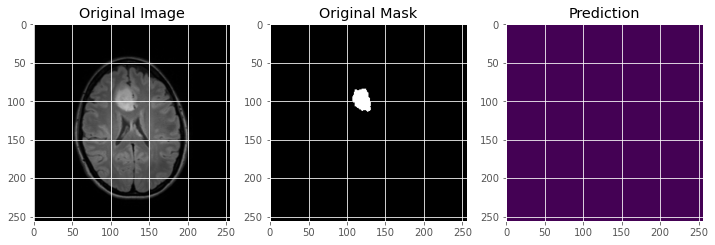

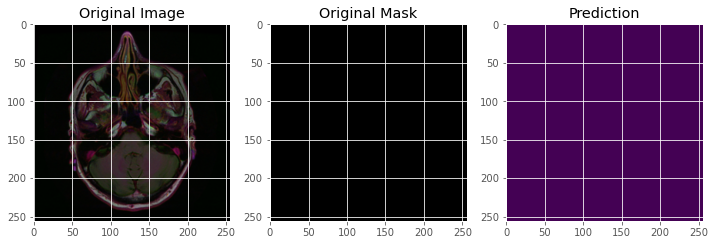

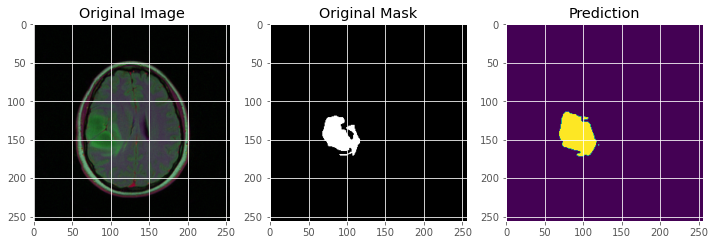

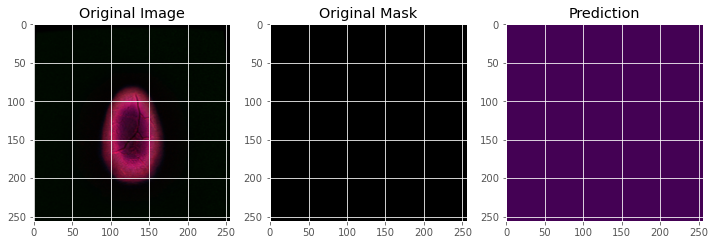

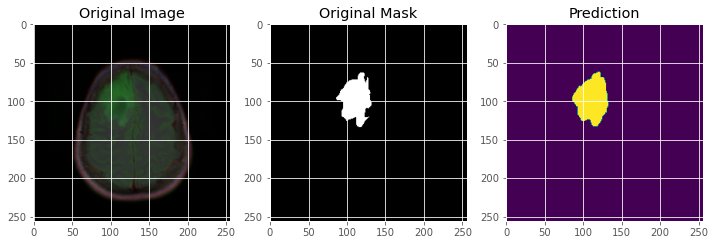

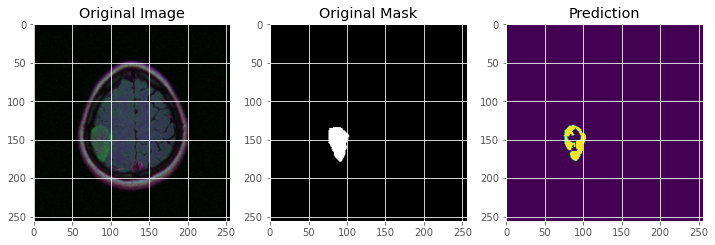

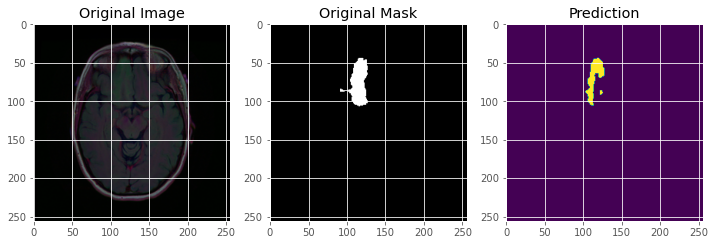

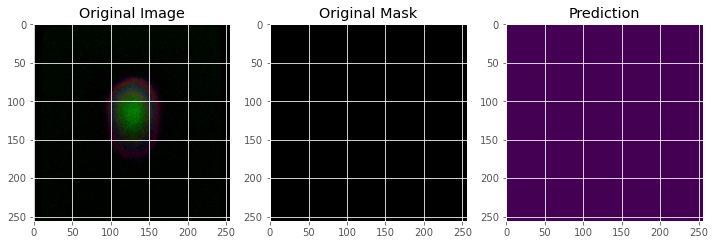

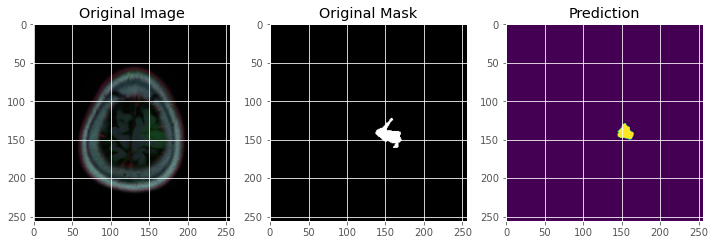

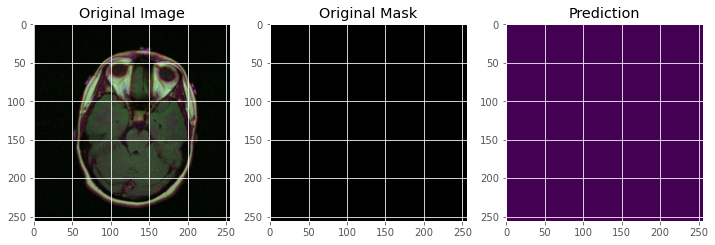

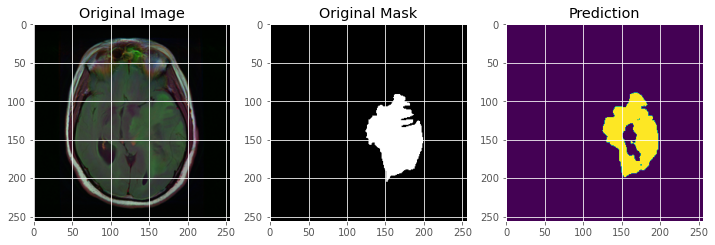

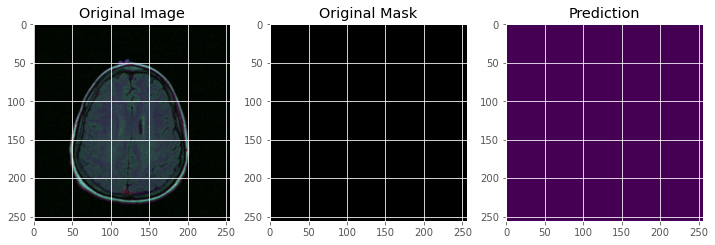

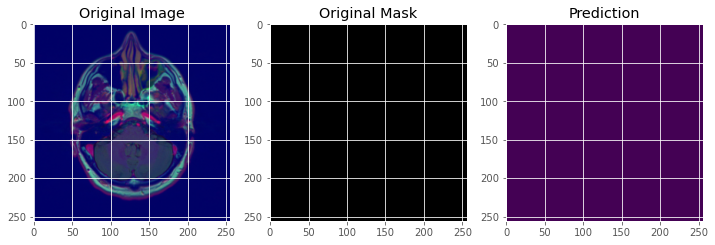

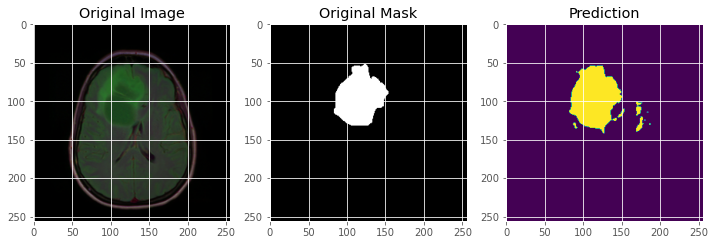

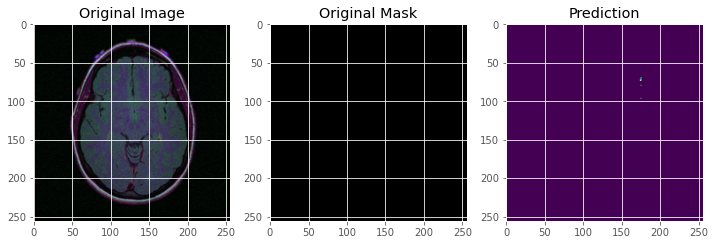

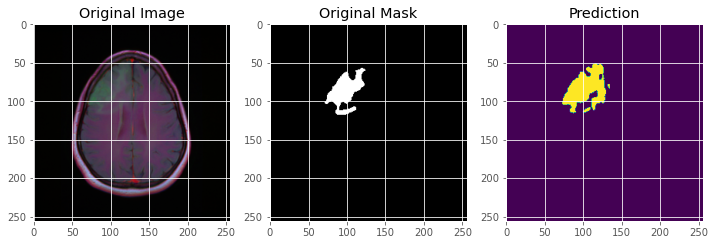

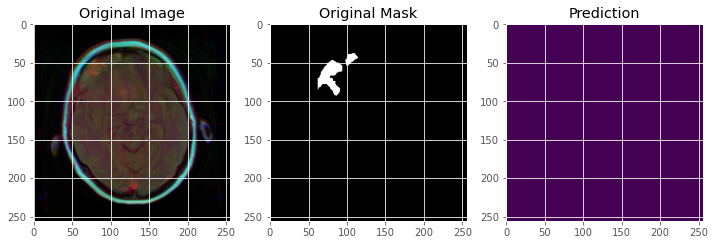

In [34]:
for i in range(30):
    index=np.random.randint(1,len(df_test.index))
    img = cv2.imread(df_test['filename'].iloc[index])
    img = cv2.resize(img ,(im_height, im_width))
    img = img / 255
    img = img[np.newaxis, :, :, :]
    pred=model.predict(img)

    plt.figure(figsize=(12,12))
    plt.subplot(1,3,1)
    plt.imshow(np.squeeze(img))
    plt.title('Original Image')
    plt.subplot(1,3,2)
    plt.imshow(np.squeeze(cv2.imread(df_test['mask'].iloc[index])))
    plt.title('Original Mask')
    plt.subplot(1,3,3)
    plt.imshow(np.squeeze(pred) > .5)
    plt.title('Prediction')
    plt.show()

    # attention based Unet
    # Unet++